In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

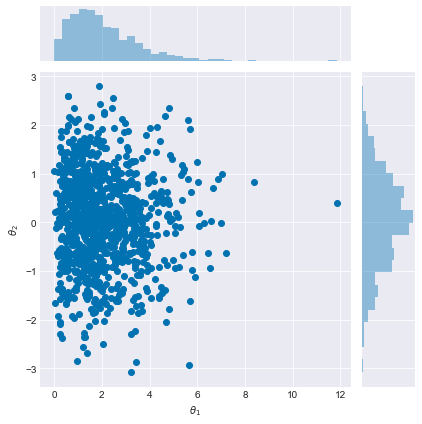

In [2]:
np.random.seed(123)
x = np.random.gamma(2, 1, 1000)
y = np.random.normal(0, 1, 1000)
data = pd.DataFrame(data=np.array([x, y]).T,
                    columns=['$\\theta_1$', '$\\theta_2$'])

sns.jointplot(x='$\\theta_1$', y='$\\theta_2$',
              data=data, stat_func=None)

plt.savefig('B04958_03_01.png', dpi=300, figsize=(5.5, 5.5))

# Gaussian inferences

In [3]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40,
                 48.45, 52.34, 55.65, 51.49, 51.86, 63.43,
                 53.00, 56.09, 51.93, 52.31, 52.33, 57.48,
                 57.44, 55.14, 53.93, 54.62, 56.09, 68.58,
                 51.36, 55.47, 50.73, 51.94, 54.95, 50.39,
                 52.91, 51.50, 52.68, 47.72, 49.73, 51.82,
                 54.99, 52.84, 53.19, 54.52, 51.46, 53.73,
                 51.61, 49.81, 52.42, 54.30, 53.84, 53.16])


# remove outliers using the interquartile rule
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
clean_data = data[(data > lower_b) & (data < upper_b)]

#print(np.mean(data), np.std(data))
#print(np.mean(clean_data), np.std(clean_data))

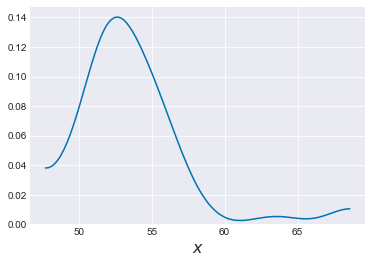

In [4]:
pm.kdeplot(data)
plt.xlabel('$x$', fontsize=16)
plt.savefig('B04958_03_02.png', dpi=300, figsize=(5.5, 5.5))

In [5]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 793.13it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.879532515088, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


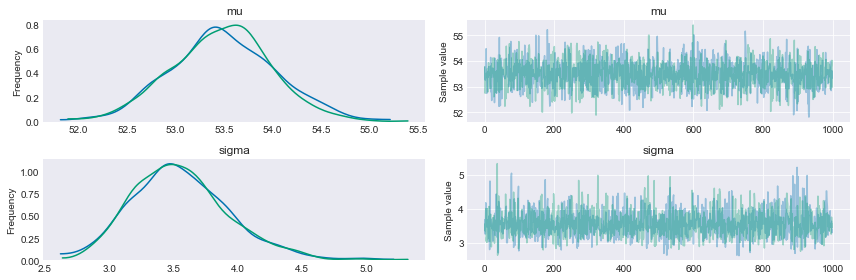

In [6]:
pm.traceplot(trace_g)
plt.savefig('B04958_03_04.png', dpi=300, figsize=(5.5, 5.5))

In [7]:
pm.summary(trace_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.48,0.53,1.11e-02,52.44,54.49,2000.0,1.0
sigma,3.56,0.38,9.81e-03,2.84,4.31,1647.0,1.0


  0%|          | 0/100 [00:00<?, ?it/s]


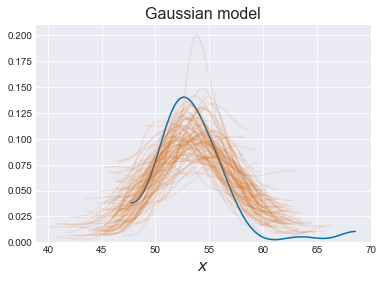

In [8]:
y_pred = pm.sample_ppc(trace_g, 100, model_g, size=len(data))
ax = pm.kdeplot(data, color='C0')
for i in y_pred['y']:
    pm.kdeplot(i, color='C2', alpha=0.1, ax=ax)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.savefig('B04958_03_04b.png', dpi=300, figsize=(5.5, 5.5))

## Gaussian Robust inferences

Now we are going to learn how to make a robust model to outliers, that is a model that do not get too much excited by outliers. For that we are going to use a Student T distribution:

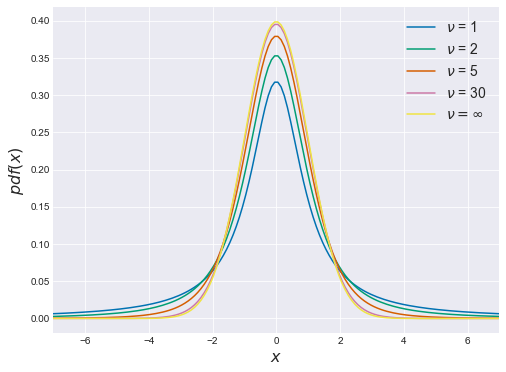

In [9]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', fontsize=16, rotation=90)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.savefig('B04958_03_05.png', dpi=300, figsize=(5.5, 5.5))

In [10]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:03<00:00, 474.24it/s]


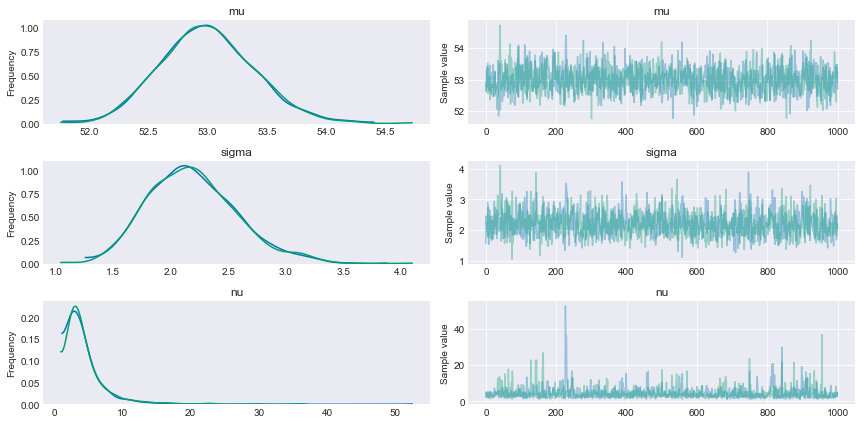

In [11]:
pm.traceplot(trace_t);
plt.savefig('B04958_03_07.png', dpi=300, figsize=(5.5, 5.5))

In [12]:
pm.summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.00,0.39,0.01,52.28,53.82,1084.0,1.0
sigma,2.19,0.39,0.01,1.43,2.95,1013.0,1.0
nu,4.54,3.37,0.12,1.25,10.32,665.0,1.0


  0%|          | 0/100 [00:00<?, ?it/s]


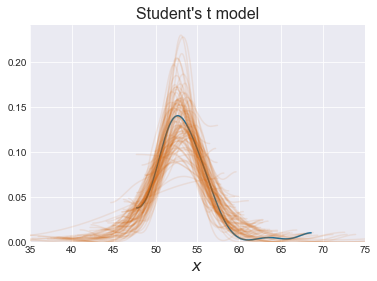

In [13]:
y_pred = pm.sample_ppc(trace_t, 100, model_t, size=len(data))
ax = pm.kdeplot(data, c='C0')
for i in y_pred['y']:
    pm.kdeplot(i, c='C2', alpha=0.1, ax=ax)
plt.xlim(35, 75)
plt.title("Student's t model", fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.savefig('B04958_03_07b.png', dpi=300, figsize=(5.5, 5.5))

# Tips example

In [14]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


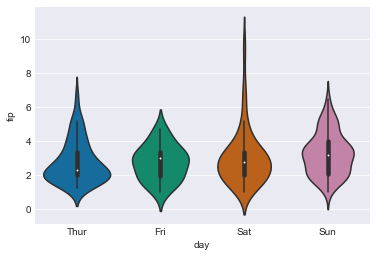

In [15]:
sns.violinplot(x='day', y='tip', data=tips);
plt.savefig('B04958_03_08.png', dpi=300, figsize=(5.5, 5.5))

In [16]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [17]:
with pm.Model() as comparing_groups:        
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))

    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:24<00:00, 227.08it/s]


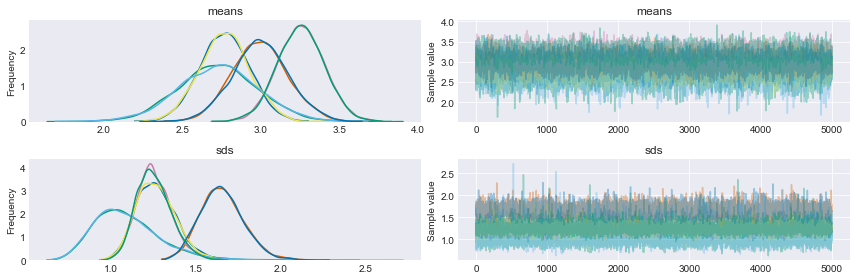

In [18]:
pm.traceplot(trace_cg);
plt.savefig('B04958_03_09.png', dpi=300, figsize=(5.5, 5.5))

In [19]:
pm.summary(trace_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,2.77,0.16,1.43e-03,2.46,3.09,10000.0,1.0
means__1,2.73,0.26,2.46e-03,2.25,3.26,9994.0,1.0
means__2,3.00,0.18,1.86e-03,2.64,3.34,10000.0,1.0
means__3,3.26,0.15,1.48e-03,2.96,3.54,10000.0,1.0
sds__0,1.27,0.12,1.14e-03,1.04,1.50,10000.0,1.0
sds__1,1.10,0.20,2.11e-03,0.75,1.49,8991.0,1.0
sds__2,1.66,0.13,1.10e-03,1.42,1.92,10000.0,1.0
sds__3,1.26,0.10,1.03e-03,1.06,1.46,9251.0,1.0


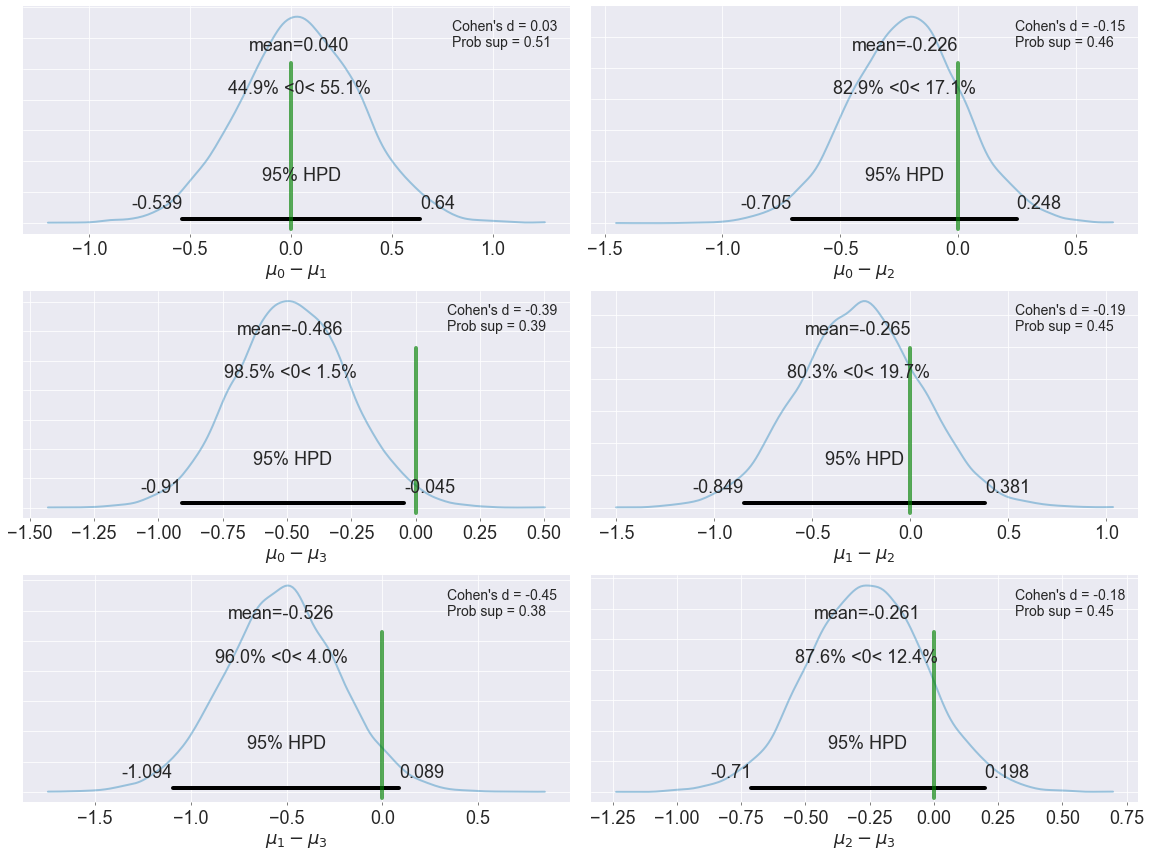

In [20]:
dist = dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['means'][:,i] - trace_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((trace_cg['sds'][:,i]**2 
                                     + trace_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
        
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], 
                      kde_plot=True, lw=2,
                      text_size=18)
    ax[k, l].plot(0,
                  label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps),
                  alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k,l ].legend(loc=0, fontsize=14)
plt.tight_layout()
plt.savefig('B04958_03_10.png', dpi=300, figsize=(5.5, 5.5))

# Hierarchical Models

In [21]:
N_samples =  [30, 30, 30]
G_samples =  [18, 18, 18] # [13, 3, 3] [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []  
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

$$\alpha \sim HalfCauchy(\beta_{\alpha})$$
$$\beta \sim HalfCauchy(\beta_{\beta})$$
$$\theta \sim Beta(\alpha, \beta)$$
$$y \sim Bern(\theta)$$

In [22]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=25)
    beta = pm.HalfCauchy('beta', beta=25)
    
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 2496/2500 [00:11<00:00, 219.48it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.575879416382, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 292 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:11<00:00, 210.32it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 107 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


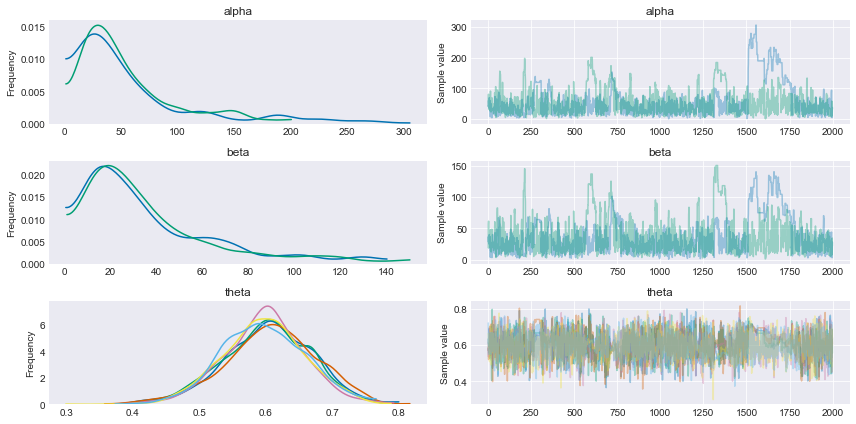

In [23]:
pm.traceplot(trace_h)
plt.savefig('B04958_03_12.png', dpi=300, figsize=(5.5, 5.5))

In [24]:
pm.summary(trace_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,57.31,49.70,4.08e+00,2.60,174.09,38.0,1.00
beta,37.23,29.60,2.25e+00,2.39,105.81,53.0,1.00
theta__0,0.60,0.06,2.23e-03,0.47,0.72,227.0,1.00
theta__1,0.60,0.06,2.29e-03,0.47,0.72,348.0,1.00
theta__2,0.60,0.07,2.74e-03,0.48,0.74,208.0,1.01


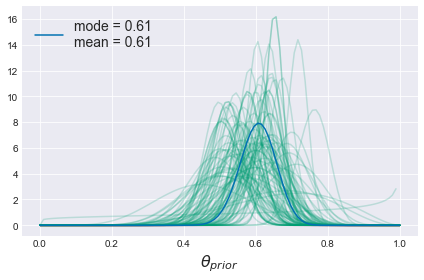

In [25]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    pdf = stats.beta(trace_h['alpha'][i], trace_h['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

dist = stats.beta(trace_h['alpha'].mean(), trace_h['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_03_13.png', dpi=300, figsize=(5.5, 5.5))

In [26]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.3
SciPy 1.0.0
Matplotlib 2.1.0
Seaborn 0.8.0
Pandas 0.20.3
